In [1]:
import jax
import numpy as np
import autograd as ag
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tidy3d.plugins.autograd.invdes import (
    make_erosion_dilation_penalty,
    get_kernel_size_px,
    make_conic_filter,
)
from tidy3d.plugins.adjoint.utils.penalty import ErosionDilationPenalty
from tidy3d.plugins.adjoint.utils.filter import ConicFilter

In [2]:
# values from inverse design notebook
radius = 0.12
dl = 0.01
beta = 50
size_px = get_kernel_size_px(radius, dl)

# random array with some shapes
x = np.random.uniform(-1, 1, (100, 100))
x[10:70, 30:50] = 1
x[20:40, 60:90] = 1

## Comparing adjoint and autograd module conic filter

In [3]:
conic_aj = ConicFilter(radius=radius, design_region_dl=dl)
conic_ag = make_conic_filter(size=size_px, padding="reflect")
conic_ag_const = make_conic_filter(size=size_px, padding="constant")

In [4]:
x_aj = conic_aj.evaluate(x)
x_ag = conic_ag(x)

# for "constant" padding, we normalize just like in the adjoint module
x_ag_norm = conic_ag_const(x)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


TypeError: unhashable type: 'list'

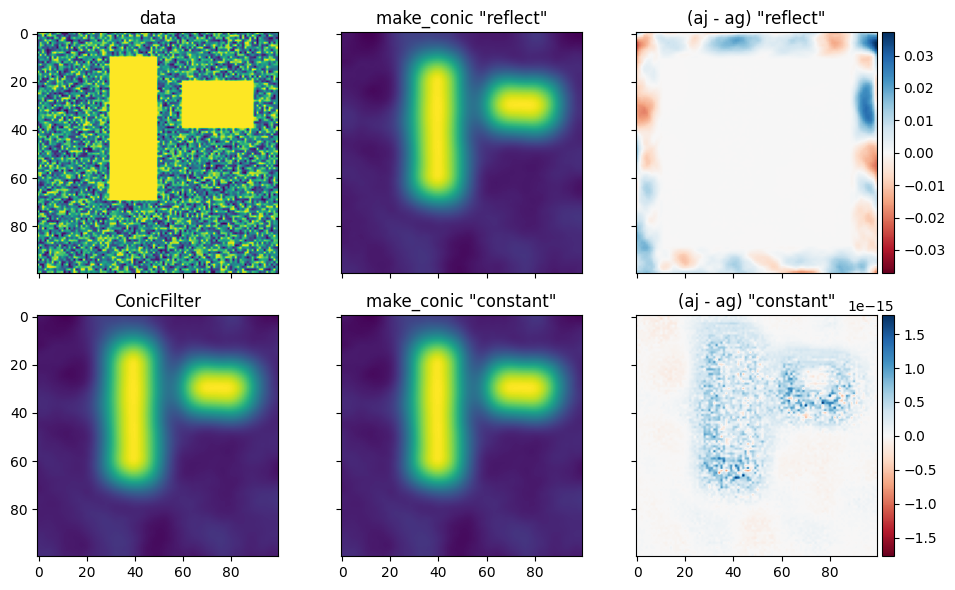

In [ ]:
fig, ax = plt.subplots(
    2,
    3,
    sharex=True,
    sharey=True,
    figsize=(10, 6),
    tight_layout=True,
)
ax[0, 0].imshow(x)
ax[1, 0].imshow(x_aj)
ax[0, 1].imshow(x_ag)
ax[1, 1].imshow(x_ag_norm)
im1 = ax[0, 2].imshow(x_aj - x_ag, cmap="RdBu", norm=CenteredNorm())
im2 = ax[1, 2].imshow(x_aj - x_ag_norm, cmap="RdBu", norm=CenteredNorm())
ax[0, 0].set_title("data")
ax[1, 0].set_title("ConicFilter")
ax[0, 1].set_title('make_conic "reflect"')
ax[1, 1].set_title('make_conic "constant"')
ax[0, 2].set_title('(aj - ag) "reflect"')
ax[1, 2].set_title('(aj - ag) "constant"')

div1 = make_axes_locatable(ax[0, 2])
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)
div2 = make_axes_locatable(ax[1, 2])
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
plt.show()

Autograd module `make_conic_filter` with `"constant"` padding and adjoint module normalization gives essentially the same result up to numerical accuracy as the adjoint `ConicFilter`.

While the new default `"reflect"` padding gives a different result, the adjoint and autograd results are still close to each other and the only difference is at the border (and it's not actually a huge difference).

## Comparing adjoint and autograd module erosion-dilation penalty

In [ ]:
penalty_ag = make_erosion_dilation_penalty(size_px)
penalty_aj = ErosionDilationPenalty(length_scale=radius, pixel_size=dl)

penalty_ag_gd = jax.grad(penalty_aj.evaluate)(x)
penalty_aj_gd = ag.grad(penalty_ag)(x)

In [ ]:
print(f"adjoint penalty:  {penalty_aj.evaluate(x)}")
print(f"autograd penalty: {penalty_ag(x)}")
print()
print(f"adjoint gradient norm:  {np.linalg.norm(penalty_aj_gd)}")
print(f"autograd gradient norm: {np.linalg.norm(penalty_ag_gd)}")

adjoint penalty:  0.3386731226456872
autograd penalty: 0.33566319280047885

adjoint gradient norm:  0.3257257600354589
autograd gradient norm: 0.3209182095803222


Both penalties give pretty much the same value and their gradient norm is also almost the same.

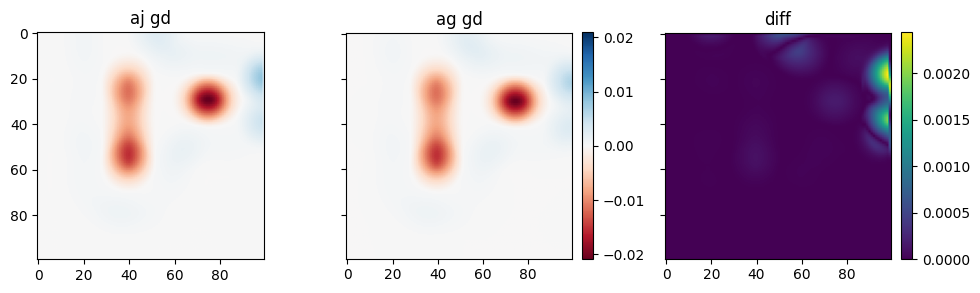

In [ ]:
fig, ax = plt.subplots(
    1,
    3,
    sharex=True,
    sharey=True,
    figsize=(10, 3),
    tight_layout=True,
)

vmin = min(penalty_aj_gd.min(), penalty_ag_gd.min())
vmax = max(penalty_aj_gd.max(), penalty_ag_gd.max())
v = max(abs(vmin), abs(vmax))
ax[0].imshow(penalty_aj_gd, cmap="RdBu", vmin=-v, vmax=v)
im1 = ax[1].imshow(penalty_ag_gd, cmap="RdBu", vmin=-v, vmax=v)
diff = np.abs(penalty_aj_gd - penalty_ag_gd)
im2 = ax[2].imshow(diff)
ax[0].set_title("aj gd")
ax[1].set_title("ag gd")
ax[2].set_title("diff")

cbar1 = fig.colorbar(
    im1,
    ax=ax[1],
    orientation="vertical",
    fraction=0.046,
    pad=0.04,
)

cbar2 = fig.colorbar(
    im2,
    ax=ax[2],
    orientation="vertical",
    fraction=0.046,
    pad=0.04,
)
plt.show()

The gradients themselves also look fine, there are some slight differences but they are minimal.